<a href="https://colab.research.google.com/github/gundasai/general/blob/master/6_Basic_Model_Upsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semantic Segmentation using Covolutional Neural Network

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing the  Library Functions

In [3]:
from keras.layers import *
import keras
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
!pip install medpy
from medpy.metric import dc, precision, recall
#!pip install -U scipy==1.2.0
import os
import cv2
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


     |████████████████████████████████| 153kB 6.9MB/s 
     |████████████████████████████████| 42.5MB 67kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753436 sha256=959f912e4126c56f36b10d6d38f706a32f5b874436dd2b6c3df240f046e64994
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#!pip install -U scipy==1.2.0
#from scipy.misc import imsave

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


### Loading Data

In [5]:
import os 
os.chdir('/content/drive/My Drive/datasets/dataset')
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1UdaOejRhEeeMQGXLjtSw0puIg-j1BFAP/dataset


In [6]:
x = np.load('Skin_ValidX.npy')
y = np.load('Skin_ValidY.npy')

print(len(x))
print(len(y))

print(x.shape)
print(y.shape)

150
150
(150, 192, 256, 3)
(150, 192, 256)


### Visualizing Data

(192, 256, 3)


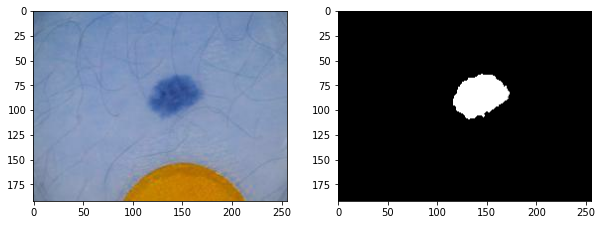

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(121).imshow(x [0],'gray')
plt.subplot(122).imshow(y [0],'gray')
print(x[0].shape)

### Data Pre-Processing
#### 1. Split and Shuffle

In [8]:
data,label = shuffle(x,y, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(data,label, test_size=0.2, random_state=2)

#### 2. Reshape

In [9]:
X_train = np.reshape(X_train,(-1,192,256,3))
y_train = np.reshape(y_train,(-1,192,256,1))

X_train = X_train.astype('float32')/255
y_train = y_train.astype('float32')/255

X_test = np.reshape(X_test,(-1,192,256,3))
y_test = np.reshape(y_test,(-1,192,256,1))

X_test = X_test.astype('float32')/255
y_test = y_test.astype('float32')/255

In [10]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(120, 192, 256, 3)
(120, 192, 256, 1)
(30, 192, 256, 3)
(30, 192, 256, 1)


#### 4. Normalization

In [11]:
mean = np.mean(X_train)
std  = np.std(X_train)

print(mean)
print(std)

X_train = X_train-mean
X_train = X_train/std

X_test = X_test-mean
X_test = X_test/std

0.58616203
0.16345002


### Model

In [12]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,Dropout

def UNet_depth2(input_shape=(192,256,3)):
    
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    
    skip1 = concatenate([up1,conv2])

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(skip1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    up2   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    
    skip2 = concatenate([up2,conv1])

    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(skip2)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    
    drop1 = Dropout(0.5)( conv5)
    conv6 = Conv2D(1, (1, 1), activation='sigmoid')(drop1)
    
    model1 = Model(inputs=[inputs], outputs=[conv6])

    return model1

model1=UNet_depth2()
model1.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 192, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 192, 256, 32) 9248        conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 96, 128, 32)  0           conv2d_12[0][0]                  
_______________________________________________________________________________________

### Model Visualization

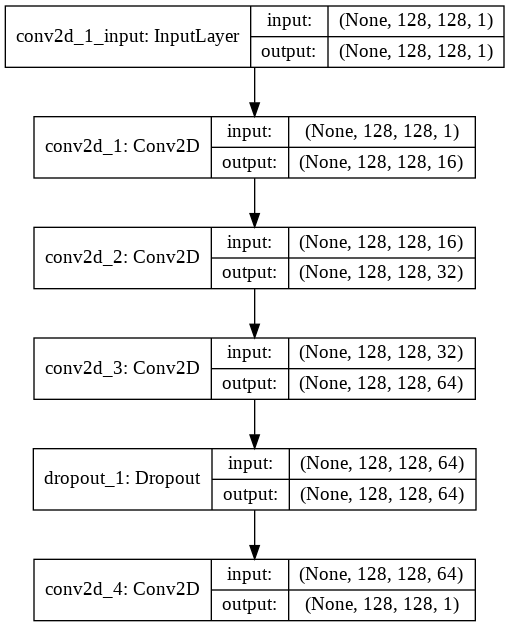

In [ ]:
os.chdir('/content/drive/My Drive/Coimbatore/Results/Architectures')
from keras.utils import plot_model
plot_model(model1, to_file='5b.png',show_shapes=True)

In [ ]:
#print(os.listdir('/content/drive/My Drive/Coimbatore/Results'))

In [ ]:
os.chdir('/content/drive/My Drive/Coimbatore/Results/Weights_and_Csv')

### Fine-tuning Tricks (callbacks)

In [13]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('FCNN_Upsample.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
cv = keras.callbacks.CSVLogger('FCNN_Upsample.csv', separator=',', append=False)

### Optimizer

In [14]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

### Compile and Train the Model

In [15]:
model1.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [17]:
from keras_preprocessing.image import ImageDataGenerator

data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    history = model1.fit(X_train,y_train,batch_size=32, epochs=100,validation_split=(0.2),verbose=1,shuffle=True)
    print('Training Completed')
                       
else:
    
    print('Using real-time data augmentation.')   
    datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=20,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False)  
    
    datagen.fit(X_train)
    history = model1.fit_generator(datagen.flow(X_train, y_train, batch_size= 32),epochs=100,samples_per_epoch=len(X_train),verbose=1,callbacks=[es,mc,cv],class_weight='auto')
    print('Training Completed')

Not using data augmentation.
Epoch 1/100
3/3 [==============================] - 1s 361ms/step - loss: 0.2222 - accuracy: 0.6841 - val_loss: 0.1700 - val_accuracy: 0.8039
Epoch 2/100
3/3 [==============================] - 1s 208ms/step - loss: 0.1546 - accuracy: 0.8173 - val_loss: 0.1643 - val_accuracy: 0.8039
Epoch 3/100
3/3 [==============================] - 1s 209ms/step - loss: 0.1452 - accuracy: 0.8209 - val_loss: 0.1619 - val_accuracy: 0.8039
Epoch 4/100
3/3 [==============================] - 1s 207ms/step - loss: 0.1408 - accuracy: 0.8278 - val_loss: 0.1516 - val_accuracy: 0.8281
Epoch 5/100
3/3 [==============================] - 1s 209ms/step - loss: 0.1380 - accuracy: 0.8318 - val_loss: 0.1493 - val_accuracy: 0.8326
Epoch 6/100
3/3 [==============================] - 1s 209ms/step - loss: 0.1318 - accuracy: 0.8394 - val_loss: 0.1522 - val_accuracy: 0.8039
Epoch 7/100
3/3 [==============================] - 1s 209ms/step - loss: 0.1278 - accuracy: 0.8361 - val_loss: 0.1435 - val_a

### Evaluating the Model Performance

In [18]:
model1.evaluate(X_test,y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0602 - accuracy: 0.9288


[0.060202427208423615, 0.9288330078125]

### Plot Loss and Accuracy

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(len(train_loss))

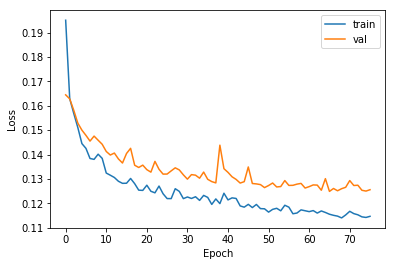

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

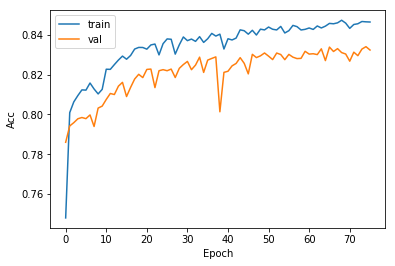

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

### Prediction

In [ ]:
#from keras.models import load_model
#model.load_weights('/content/drive/My Drive/Coimbatore/Results/Weights_and_Csv/FCNN_Constan_Kernel.h5')

In [19]:
a = np.reshape(X_test[10],(192,256,3))#2 35
b = np.reshape(y_test[10],(192,256))

c = np.copy(a)
d = np.copy(b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


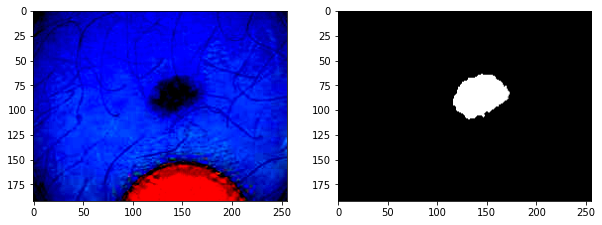

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(121).imshow(a, 'gray')
plt.subplot(122).imshow(b,'gray')

In [21]:
testing_image = np.reshape(X_test[10], (1,192,256,3))

In [22]:
prediction = model1.predict(testing_image)
prediction.shape
prediction = prediction.reshape((192,256))

0.0
0.9998919


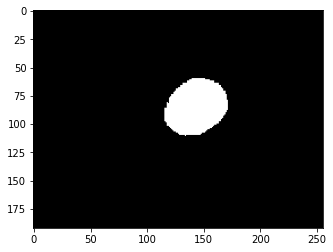

In [23]:
sample = prediction > 0.5
print(np.min(prediction))
print(np.max(prediction))
plt.imshow(sample, cmap = "gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'PREDICTION')

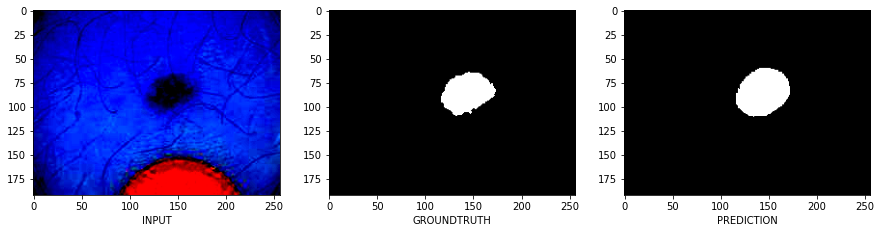

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(131).imshow(c,'gray')
plt.xlabel('INPUT')

plt.subplot(132).imshow(d,'gray')
plt.xlabel('GROUNDTRUTH')

plt.subplot(133).imshow(sample,'gray')
plt.xlabel('PREDICTION')

### Dice Coefficient

In [25]:
test_pred = model1.predict(X_test, batch_size=32)
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.5] = 1
test_result[test_pred<=0.5] = 0
dice = dc(test_result, y_test)
pre  = precision(test_result,y_test)
re   = recall(test_result,y_test)
print('Test dc: '  + str(dice))
print('Test pre: ' + str(pre))
print('Test re: '  + str(re))

Test dc: 0.7246969935463561
Test pre: 0.7800481176510454
Test re: 0.6766806784443987
